In [1]:
import copy
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.nn import FFNN

In [2]:
DATA = '../daily/data'
N_MODS = 3

Mutate: False


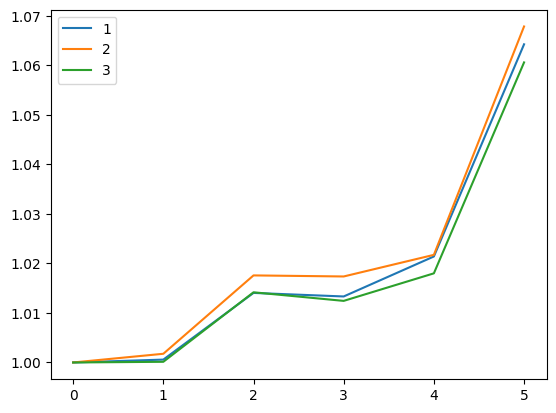

In [3]:
N_NEEDED = 9

perf1 = np.array([103273,103333,104724,104650,105484,109910])
perf2 = np.array([102405,102585,104206,104184,104631,109355])
perf3 = np.array([102642,102656,104097,103919,104490,108863])

MUTATE = len(perf1) - 1 >= N_NEEDED
print('Mutate:', MUTATE)

buying_power = [ 11967, 10063, 12245]

plt.plot(perf1 / perf1[0], label='1')
plt.plot(perf2 / perf2[0], label='2')
plt.plot(perf3 / perf3[0], label='3')
plt.legend();

In [4]:
BEST = 2  # [1, 2, 3]
MUTATE_SCALE = 0.49005  # x0.9 or x1.1 decrease if same; incr if new

In [5]:
metrics = pd.read_csv(f'{DATA}/stock_metrics.csv')
metrics.head()

,stock,price,direction,RSI,RSIRev,fair_value_mult,geomean,sharpe
0,AAPL,205.350006,1,0.323741,0.676259,0.497615,0.179348,0.818854
1,ABNB,125.260002,1,0.731864,0.268136,0.798731,0.367722,0.178402
2,ACN,305.329987,1,0.505196,0.494804,0.860493,0.089883,0.657585
3,ADBE,380.869995,1,0.561551,0.438449,0.856916,0.096990,0.649796
4,AMD,98.800003,1,0.546363,0.453637,0.756757,0.188545,0.925974


In [6]:
x = metrics[['direction', 'RSI', 'fair_value_mult', 'geomean', 'sharpe']]

In [7]:
states = [None] * N_MODS
try:
    with open(f'{DATA}/ffnn_states.pkl', 'rb') as f:
        states = pickle.load(f)
        print('States recovered')
except FileNotFoundError:
    print('Creating new states...')
    states = [None] * N_MODS

States recovered


In [8]:
len(states)

3

In [9]:
mods = []
for state in states:
    mod = FFNN(**state) if state is not None else FFNN(5, [5])
    mods.append(mod)

In [10]:
if MUTATE:
    print('mutating...')
    best_state = mods[BEST - 1].get_state()
    mods = [mods[BEST - 1]]

    for _ in range(1, N_MODS):
        new_mod = FFNN(**copy.deepcopy(best_state))
        new_mod.mutate(scale=MUTATE_SCALE)
        mods.append(new_mod)
else:
    print('do nothing')

do nothing


In [11]:
len(mods)

3

In [12]:
#for mod in mods:
#    print(mod.Ws)

In [13]:
def get_holdings(filename, i):
    df = pd.read_csv(f'~/Downloads/ffnn/{filename}')
    df = df[['Symbol', 'Value']]
    df.Value = df.Value.str.replace('$', '').str.replace(',', '').astype(float)
    df.columns = ['stock', f'holdings{i + 1}']
    df.set_index('stock', drop=True, inplace=True)
    return df

In [14]:
holdings_files = sorted([f for f in os.listdir('/Users/damiansp/Downloads/ffnn') if f.endswith('.csv')])
holdings = pd.concat([get_holdings(f, i) for i, f in enumerate(holdings_files)], axis=1)
holdings.fillna(0, inplace=True)
holdings.head()

,holdings1,holdings2,holdings3
stock,,,
AAON,1093.07,496.85,1093.07
AAPL,821.40,616.05,821.40
ABBV,595.41,595.41,793.88
ABNB,626.30,1252.60,1127.34
ABT,531.28,0.00,0.00


In [15]:
out = pd.DataFrame({'stock': metrics.stock, 'price': metrics.price.round(2)})
cols = []
for i, mod in enumerate(mods):
    value = mod.forward_pass(x, 'relu', 'sigmoid')
    value = value.squeeze()
    value /= np.sum(value)
    col = pd.Series(value, name=f'val{i + 1}')
    cols.append(col)
out = pd.concat([out, *cols], axis=1)
out.head()

,stock,price,val1,val2,val3
0,AAPL,205.35,0.008079,0.008326,0.006915
1,ABNB,125.26,0.004433,0.005520,0.006244
2,ACN,305.33,0.006096,0.003417,0.005878
3,ADBE,380.87,0.006137,0.003555,0.006065
4,AMD,98.80,0.007853,0.005509,0.006836


In [16]:
for h in [1, 2, 3]:
    invested_amt = holdings[f'holdings{h}'].sum()
    buying_power[h - 1] += invested_amt
print(buying_power)
amt_in = []
for i, d in enumerate(buying_power):
    amt = (d * out[f'val{i + 1}']).round(2)
    amt_in.append(pd.Series(amt, name=f'amt{i + 1}'))
out = pd.concat([out, *amt_in], axis=1)
out.set_index('stock', inplace=True, drop=True)
out.head()

[219819.85, 218710.37, 217725.46000000002]


,price,val1,val2,val3,amt1,amt2,amt3
stock,,,,,,,
AAPL,205.35,0.008079,0.008326,0.006915,1775.89,1820.88,1505.47
ABNB,125.26,0.004433,0.005520,0.006244,974.54,1207.28,1359.57
ACN,305.33,0.006096,0.003417,0.005878,1340.09,747.30,1279.88
ADBE,380.87,0.006137,0.003555,0.006065,1349.08,777.61,1320.48
AMD,98.80,0.007853,0.005509,0.006836,1726.29,1204.98,1488.36


In [17]:
out = pd.concat([out, holdings], axis=1)
out.fillna(0, inplace=True)
out.head()

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3
stock,,,,,,,,,,
AAPL,205.35,0.008079,0.008326,0.006915,1775.89,1820.88,1505.47,821.40,616.05,821.40
ABNB,125.26,0.004433,0.005520,0.006244,974.54,1207.28,1359.57,626.30,1252.60,1127.34
ACN,305.33,0.006096,0.003417,0.005878,1340.09,747.30,1279.88,915.99,915.99,915.99
ADBE,380.87,0.006137,0.003555,0.006065,1349.08,777.61,1320.48,1142.61,380.87,1142.61
AMD,98.80,0.007853,0.005509,0.006836,1726.29,1204.98,1488.36,790.40,790.40,790.40


In [18]:
for i in range(N_MODS):
    out[f'diff{i + 1}'] = out[f'amt{i + 1}'] - out[f'holdings{i + 1}']
out.head()

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3,diff1,diff2,diff3
stock,,,,,,,,,,,,,
AAPL,205.35,0.008079,0.008326,0.006915,1775.89,1820.88,1505.47,821.40,616.05,821.40,954.49,1204.83,684.07
ABNB,125.26,0.004433,0.005520,0.006244,974.54,1207.28,1359.57,626.30,1252.60,1127.34,348.24,-45.32,232.23
ACN,305.33,0.006096,0.003417,0.005878,1340.09,747.30,1279.88,915.99,915.99,915.99,424.10,-168.69,363.89
ADBE,380.87,0.006137,0.003555,0.006065,1349.08,777.61,1320.48,1142.61,380.87,1142.61,206.47,396.74,177.87
AMD,98.80,0.007853,0.005509,0.006836,1726.29,1204.98,1488.36,790.40,790.40,790.40,935.89,414.58,697.96


In [19]:
out = out[((out.price.notnull()) & (out.price > 0))]

In [20]:
for i in range(N_MODS):
    out[f'shares{i + 1}'] = (out[f'diff{i + 1}'] / out.price).round().astype('Int64')
out = out[out.price >= 2]
out

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3,diff1,diff2,diff3,shares1,shares2,shares3
stock,,,,,,,,,,,,,,,,
AAPL,205.35,0.008079,0.008326,0.006915,1775.89,1820.88,1505.47,821.40,616.05,821.40,954.49,1204.83,684.07,5,6,3
ABNB,125.26,0.004433,0.005520,0.006244,974.54,1207.28,1359.57,626.30,1252.60,1127.34,348.24,-45.32,232.23,3,0,2
ACN,305.33,0.006096,0.003417,0.005878,1340.09,747.30,1279.88,915.99,915.99,915.99,424.10,-168.69,363.89,1,-1,1
ADBE,380.87,0.006137,0.003555,0.006065,1349.08,777.61,1320.48,1142.61,380.87,1142.61,206.47,396.74,177.87,1,1,0
AMD,98.80,0.007853,0.005509,0.006836,1726.29,1204.98,1488.36,790.40,790.40,790.40,935.89,414.58,697.96,9,4,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VTRS,8.65,0.001264,0.003153,0.004883,277.85,689.66,1063.15,0.00,700.65,960.15,277.85,-10.99,103.00,32,-1,12
WING,270.11,0.007166,0.003853,0.006713,1575.16,842.79,1461.60,1080.44,1080.44,1080.44,494.72,-237.65,381.16,2,-1,1
WIT,2.90,0.003723,0.005248,0.005577,818.44,1147.88,1214.32,1038.20,1197.70,855.50,-219.76,-49.82,358.82,-76,-17,124


<span style="color: red">CHECK URL!</span>

In [21]:
o = out.sort_values('diff1', ascending=False)[['price', 'diff1', 'shares1']]
o[o.shares1 != 0].head(5)

,price,diff1,shares1
stock,,,
EEM,45.00,987.63,22
HWM,154.07,965.97,6
TMO,423.55,961.10,2
LGIH,55.09,957.50,17
AAPL,205.35,954.49,5


In [22]:
o[o.shares1 != 0].tail(5)

,price,diff1,shares1
stock,,,
BXP,65.05,-176.78,-3
DASH,205.09,-178.03,-1
TTC,70.67,-201.51,-3
WIT,2.90,-219.76,-76
NKE,58.59,-474.24,-8


<span style="color: red">SERIOUSLY....</span></br>
<span style="color: red">CHECK URL!</span>

In [24]:
o = out.sort_values('diff2', ascending=False)[['price', 'diff2', 'shares2']]
o[o.shares2 != 0].head(5)

,price,diff2,shares2
stock,,,
GDX,47.08,1649.88,35
FNV,164.92,1599.13,10
PG,160.52,1593.48,10
NEM,51.53,1579.09,31
MELI,2280.69,1498.83,1


In [25]:
o[o.shares2 != 0].tail(5)

,price,diff2,shares2
stock,,,
EMR,108.32,-616.97,-6
NKE,58.59,-628.49,-11
QBTS,7.91,-834.80,-106
SMLR,36.16,-1101.03,-30
SBUX,84.69,-1393.63,-16


In [26]:
o = out.sort_values('diff3', ascending=False)[['price', 'diff3', 'shares3']]
o[o.shares3 != 0].head(5)

,price,diff3,shares3
stock,,,
AMZN,189.98,870.72,5
WMT,98.75,867.64,9
QTUM,77.91,853.56,11
FTNT,106.18,830.56,8
MCK,708.41,815.78,1


In [27]:
o[o.shares3 != 0].tail(5)

,price,diff3,shares3
stock,,,
QBTS,7.91,40.98,5
NVO,69.23,37.05,1
BROS,61.10,32.78,1
RGTI,10.63,-166.04,-16
NKE,58.59,-178.87,-3


In [28]:
if MUTATE:
    states = [mod.get_state() for mod in mods]
    with open(f'{DATA}/ffnn_states.pkl', 'wb') as f:
        pickle.dump(states, f)
    print('States saved')
else:
    print('Did nothing')

Did nothing
